In [15]:
%load_ext autoreload
%autoreload 2

import sys
import os

dir_name = '/home/guerrini/sp_validation/notebooks/cosmo_val'
if dir_name not in sys.path:
    sys.path.append(dir_name)

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
import camb
from cosmology import Cosmology
from cosmo_val import CosmologyValidation
import pyccl as ccl
import fitsio

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
root_dir = '/n17data/mkilbing/astro/data/CFIS/v1.0/ShapePipe/'
glass_mock = 'unions_v1.4.5_glass_mock.fits'
target_mock = '/v1.4.x/v1.4.5/unions_shapepipe_cut_struc_2024_v1.4.5.fits'

cats = [glass_mock, target_mock]
labels = ['glass_mock', 'target_mock']
w_cols = ['w', 'w_iv'] 

In [3]:
#Create n_gal maps
for cat, label, w_col in zip(cats, labels, w_cols):
    data = fits.getdata(root_dir + cat)
    n_gal = np.zeros(hp.nside2npix(4096))
    
    ra = data['ra']
    dec = data['dec']
    pix = hp.ang2pix(4096, np.radians(90 - dec), np.radians(ra))

    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_gal[unique_pix] = np.bincount(idx_rep)
    mask = n_gal != 0

    area = np.sum(mask) * hp.nside2pixarea(4096, degrees=True)
    print(f"Area of {label} = {area} deg^2")
    del n_gal, mask

    #Compute effective number of galaxies
    e1 = data['e1']
    e2 = data['e2']

    n_eff_gal = 1/(area*60*60)*(np.sum(data[w_col]))**2/np.sum(data[w_col]**2)
    print(f"n_eff_gal of {label} = {n_eff_gal} arcmin^-2")

    #Compute shape noise
    sigma_e = np.sqrt(
    0.5*(np.sum((data['e1']*data[w_col])**2) + np.sum((data['e2']*data[w_col])**2)) / np.sum(data[w_col]**2)
    )
    print(f"sigma_e of {label} = {sigma_e}")

Area of glass_mock = 2782.7047184353864 deg^2
n_eff_gal of glass_mock = 7.180823982291946 arcmin^-2
sigma_e of glass_mock = 0.3090765119338302
Area of target_mock = 2807.3286432235495 deg^2
n_eff_gal of target_mock = 7.127619407438543 arcmin^-2
sigma_e of target_mock = 0.3093694972219397


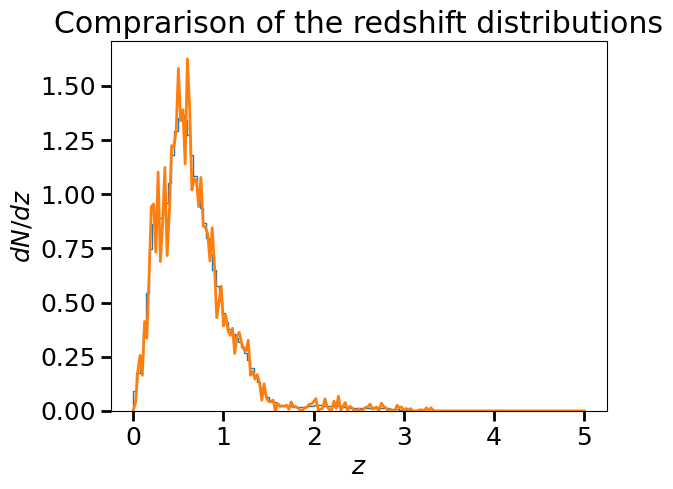

In [4]:
#Check the redshift distribution
glass_cat = fits.getdata(root_dir + glass_mock)

plt.figure()

plt.hist(glass_cat['PHOTO_Z'], bins=100, histtype='step', label='glass_mock', density=True)

redshift_distr = np.loadtxt('/n17data/mkilbing/astro/data/CFIS/v1.0/nz/dndz_SP_A.txt')
z, dndz = redshift_distr[:, 0], redshift_distr[:, 1]

plt.plot(z, dndz, label='SP_A')

plt.xlabel(r'$z$')
plt.ylabel(r'$dN/dz$')
plt.title('Comprarison of the redshift distributions')

plt.show()


In [16]:
#Checking if the mock has the correct power spectrum
cv = CosmologyValidation(
    versions=["SP_v1.4.5_glass_mock"],
    data_base_dir="/n17data/mkilbing/astro/data/",
    npatch=100,
    catalog_config='/home/guerrini/sp_validation/notebooks/cosmo_val/cat_config.yaml',
)

Plotting pseudo-Cl's

Computing pseudo-Cl's
SP_v1.4.5_glass_mock
Creating maps and computing Cl's...
Saving pseudo-Cl's...
Done pseudo-Cl's

Computing Pseudo-Cl covariance
SP_v1.4.5_glass_mock
Extracting the fiducial power spectrum for SP_v1.4.5_glass_mock
Getting a sample of the fiducial Cl's with noise
Computing the Pseudo-Cl covariance
Saving Pseudo-Cl covariance
Done Pseudo-Cl covariance


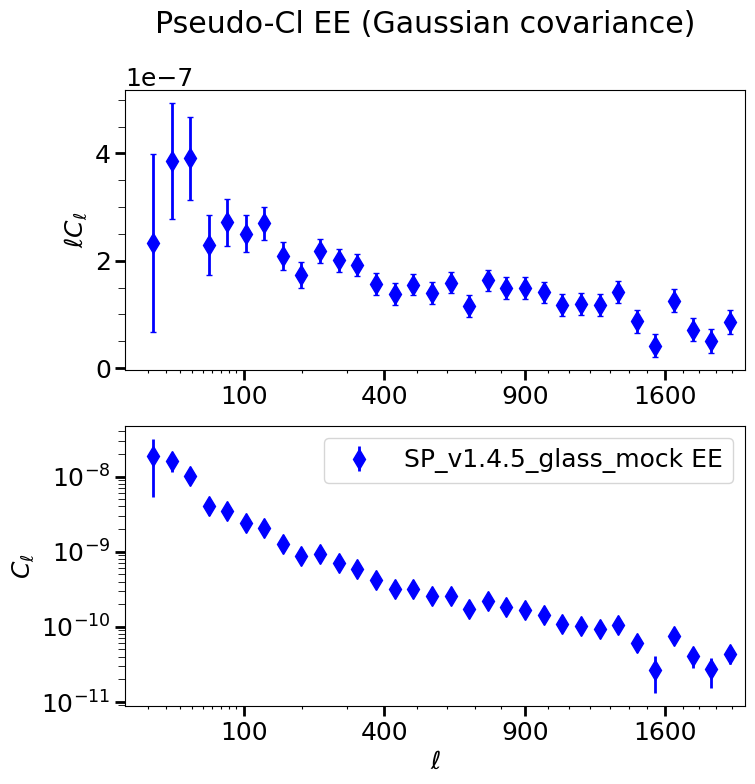

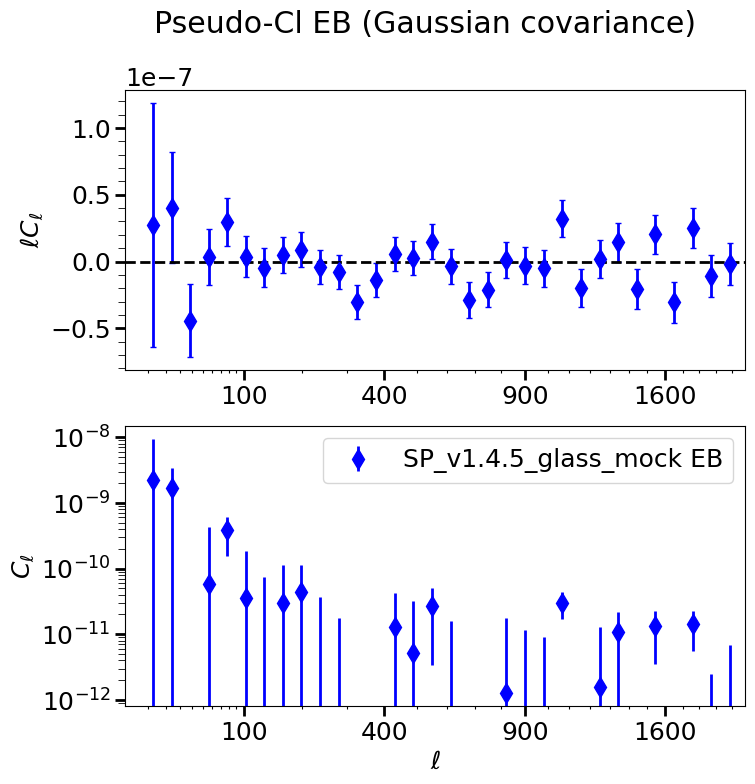

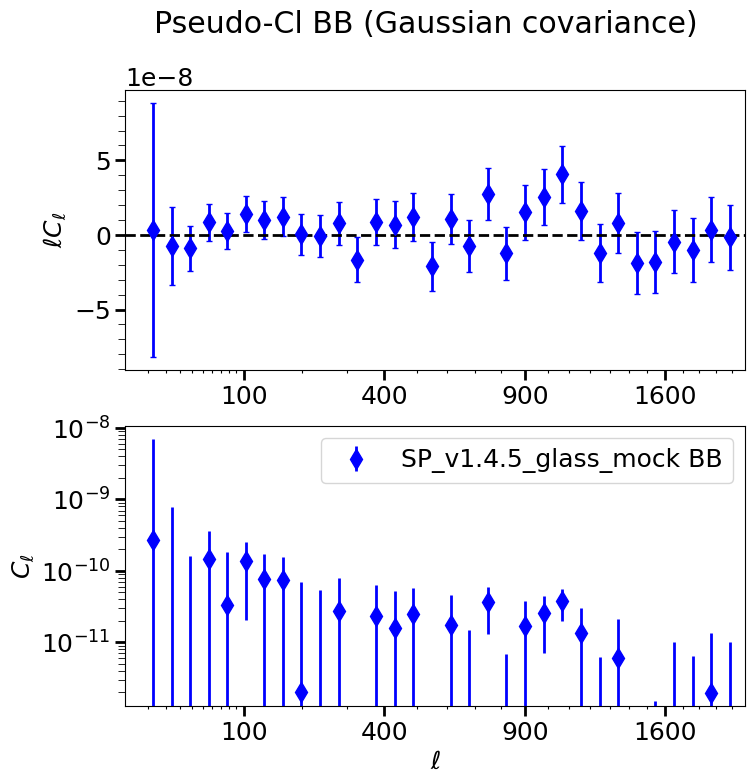

In [6]:
cv.plot_pseudo_cl()

In [7]:
#Compute theory Cl'set
h = 0.7
Oc = 0.25
Ob = 0.05

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                                    NonLinear=camb.model.NonLinear_both, WantTransfer=True)

nside = 1024
lmax = 2*nside

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)


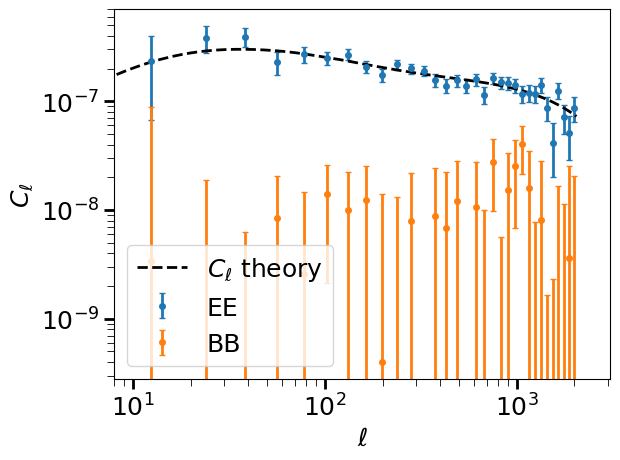

In [8]:
l = np.arange(lmax+1)
pw = hp.pixwin(nside, lmax=lmax)

pseudo_cl_glass = fits.getdata('./output/pseudo_cl_SP_v1.4.5_glass_mock.fits')
cov_cl_glass = fits.open('./output/pseudo_cl_cov_SP_v1.4.5_glass_mock.fits')

ell_eff = pseudo_cl_glass['ELL']

plt.figure()

plt.errorbar(ell_eff, ell_eff*pseudo_cl_glass['EE'], yerr=ell_eff*np.sqrt(np.diag(cov_cl_glass["COVAR_EE_EE"].data)), fmt='o', capsize=2, markersize=4, label='EE')
plt.errorbar(ell_eff, ell_eff*pseudo_cl_glass['BB'], yerr=ell_eff*np.sqrt(np.diag(cov_cl_glass["COVAR_BB_BB"].data)), fmt='o', capsize=2, markersize=4, label='BB')
plt.plot(l, l*theory_cls['W1xW1']*pw**2, label=r'$C_\ell$ theory', c='k', ls='--')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(8, 3*nside-1)

plt.show()


Computing 2PCF
SP_v1.4.5_glass_mock

Loading catalog for SP_v1.4.5_glass_mock
Catalog loaded for SP_v1.4.5_glass_mock

Calculating additive bias:
SP_v1.4.5_glass_mock
Finished additive bias calculation.
Freeing SP_v1.4.5_glass_mock from memory
Done 2PCF
n_pair plot saved to /automnt/n17data/sguerrini/sp_validation/glass_mock/output/n_pair.png
xi_plus plot saved to /automnt/n17data/sguerrini/sp_validation/glass_mock/output/xi_p.png
xi_minus plot saved to /automnt/n17data/sguerrini/sp_validation/glass_mock/output/xi_m.png
xi_plus_theta plot saved to /automnt/n17data/sguerrini/sp_validation/glass_mock/output/xi_p_theta.png
xi_minus_theta plot saved to /automnt/n17data/sguerrini/sp_validation/glass_mock/output/xi_m_theta.png

Rho stats
Compute Rho and Tau statistics for the version:  SP_v1.4.5_glass_mock
Building catalogs...


KeyboardInterrupt: 

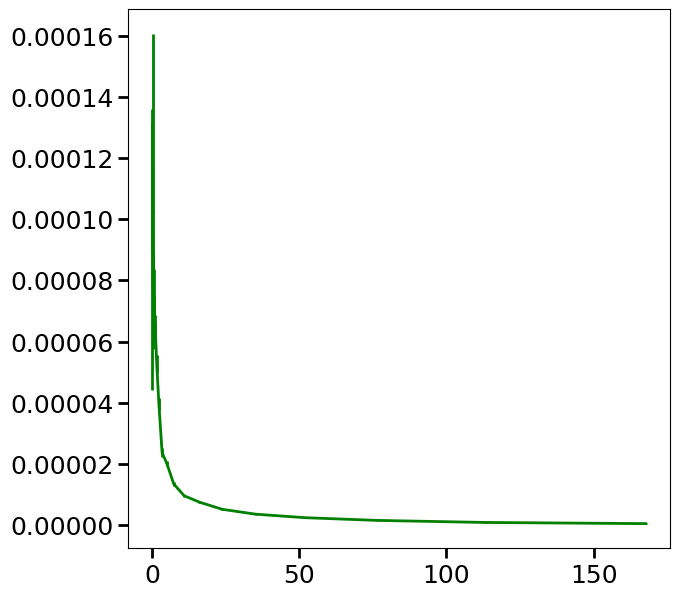

In [17]:
#Check correlation function fits theory
cv.plot_2pcf()

In [19]:
#Get theory correlation function from CCL
#Define the cosmology
theta_arcmin = np.logspace(np.log10(0.1), np.log10(250), 1000)
h = 0.7
Oc = 0.25
Ob = 0.05
sigma8 = 0.793897
n_s = 0.96
cosmo = ccl.Cosmology(
    h=h,
    Omega_c = Oc,
    Omega_b = Ob,
    sigma8 = sigma8,
    n_s = n_s,
    transfer_function='boltzmann_camb',
)

#Define the redshift distribution
z, dndz = np.loadtxt('/home/guerrini/sp_validation/cosmo_inference/cosmocov_config/dndz_test.txt', unpack=True)

tracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz), ia_bias=None)

#COmpute the angular power spectrum C_ell
ell = np.logspace(0, np.log10(10000), 2000)
cl_gg = ccl.angular_cl(cosmo, tracer, tracer, ell)

#Compute the 2PCF
theta_deg = theta_arcmin / 60
#xi+ fit
xi_p_theta = ccl.correlation(cosmo, ell=ell, C_ell=cl_gg, theta=theta_deg, type='GG+')
#xi- fit
xi_m_theta = ccl.correlation(cosmo, ell=ell, C_ell=cl_gg, theta=theta_deg, type='GG-')

In [18]:
import treecorr

theta_min = 0.1
theta_max = 250.0
nbins = 20
var_method = 'jackknife'

treecorr_config = {
            "ra_units": "degrees",
            "dec_units": "degrees",
            "min_sep": theta_min,
            "max_sep": theta_max,
            "sep_units": "arcmin",
            "nbins": nbins,
            "var_method": var_method,
        }

gg = treecorr.GGCorrelation(treecorr_config)

glass_cat = fits.getdata(root_dir + glass_mock)

cat_gal = treecorr.Catalog(
    ra=glass_cat['ra'],
    dec=glass_cat['dec'],
    ra_units='degrees',
    dec_units='degrees',
    w=glass_cat['w'],
    g1=glass_cat['e1'],
    g2=-glass_cat['e2'],
)

gg.process(cat_gal)

KeyboardInterrupt: 

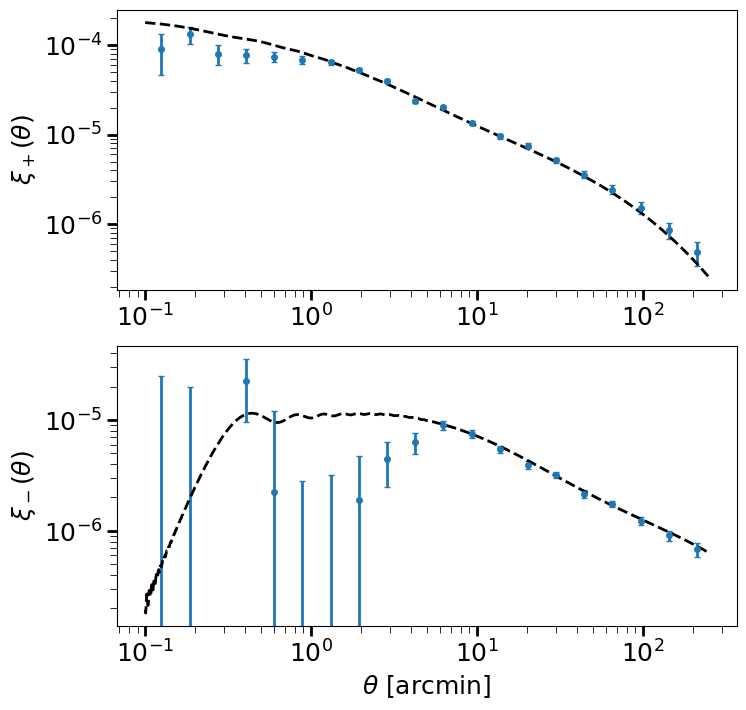

In [20]:
import treecorr 

theta_min = 0.1
theta_max = 250.0
nbins = 20
var_method = 'jackknife'

treecorr_config = {
            "ra_units": "degrees",
            "dec_units": "degrees",
            "min_sep": theta_min,
            "max_sep": theta_max,
            "sep_units": "arcmin",
            "nbins": nbins,
            "var_method": var_method,
        }

gg = treecorr.GGCorrelation(treecorr_config)

#Load the measurement
gg.read('output/xi_pm_SP_v1.4.5_glass_mock.txt')


plt.figure(figsize=(8, 8))

plt.subplot(211)

plt.errorbar(gg.meanr, gg.xip, yerr=np.sqrt(gg.varxip), fmt='o', label=r'$\xi_+$ data', capsize=2, markersize=4)
plt.plot(theta_arcmin, xi_p_theta, label=r'$\xi_+$ theory', linestyle='--', color='black')

plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'$\xi_+(\theta)$')

plt.subplot(212)

plt.errorbar(gg.meanr, gg.xim, yerr=np.sqrt(gg.varxim), fmt='o', label=r'$\xi_-$ data', capsize=2, markersize=4)
plt.plot(theta_arcmin, xi_m_theta, label=r'$\xi_-$ theory', linestyle='--', color='black')

plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'$\xi_-(\theta)$')
plt.xlabel(r'$\theta$ [arcmin]')

plt.show()